# Capstone Project - Week 1
## Function 7: 6D Optimization Challenge
### Initial Data Exploration and Analysis

**Date:** January 27, 2026

**Objective:** Maximize F7 using Bayesian Optimization

**Approach:** 
- Load and explore initial 6D samples
- Fit Gaussian Process surrogate model
- Use Expected Improvement for next point selection
- Look at UCB next point selection

## Section 1: Import Required Libraries

In [128]:
# Core scientific computing libraries
import numpy as np
import matplotlib.pyplot as plt

# Gaussian Process regression and optimization
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern
from scipy.stats import norm
from scipy.optimize import minimize

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print(f'Libraries loaded successfully for F7 (6D)')

Libraries loaded successfully for F7 (6D)


## Section 2: Load Initial Data

Loading Week 1 initial samples for Function 7

In [129]:
# Define file paths for F7
INPUT_FILE = 'f7_initial_inputs.npy'   # Shape: (n_samples, 6)
OUTPUT_FILE = 'f7_initial_outputs.npy' # Shape: (n_samples,)

In [130]:
# Load data
X = np.load(INPUT_FILE)  # Input matrix
Y = np.load(OUTPUT_FILE) # Output vector

# Display data information
print('F7 Data Loaded:')
print(f'  Input shape:  {X.shape}')
print(f'  Output shape: {Y.shape}')
print(f'  Dimensions:   {X.shape[1]}D')
print(f'  Samples:      {len(X)}')

F7 Data Loaded:
  Input shape:  (30, 6)
  Output shape: (30,)
  Dimensions:   6D
  Samples:      30


## Section 3: Exploratory Data Analysis

In [131]:
# Ensure proper data format
X = np.atleast_2d(X)
Y = Y.ravel()

print('='*70)
print('FUNCTION 7 - INITIAL DATA ANALYSIS')
print('='*70)

# Output statistics
print(f'\nOutput Statistics:')
print(f'  Maximum:  {Y.max():.6f}')
print(f'  Minimum:  {Y.min():.6f}')
print(f'  Mean:     {Y.mean():.6f}')
print(f'  Median:   {np.median(Y):.6f}')
print(f'  Std Dev:  {Y.std():.6f}')
print(f'  Range:    {Y.max() - Y.min():.6f}')

# Find best point
best_idx = np.argmax(Y)
best_value = Y[best_idx]
best_point = X[best_idx]

print(f'\n🎯 Best Point Found (Initial Sampling):')
print(f'  Value:    {best_value:.6f}')
print(f'  Location: {best_point}')

# Input space coverage
print(f'\nInput Space Coverage:')
for i in range(X.shape[1]):
    print(f'  X{i+1}: [{X[:, i].min():.4f}, {X[:, i].max():.4f}]')

FUNCTION 7 - INITIAL DATA ANALYSIS

Output Statistics:
  Maximum:  1.364968
  Minimum:  0.002701
  Mean:     0.219607
  Median:   0.078631
  Std Dev:  0.302129
  Range:    1.362267

🎯 Best Point Found (Initial Sampling):
  Value:    1.364968
  Location: [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]

Input Space Coverage:
  X1: [0.0579, 0.9425]
  X2: [0.0118, 0.9247]
  X3: [0.0036, 0.9246]
  X4: [0.0737, 0.9610]
  X5: [0.0149, 0.9987]
  X6: [0.0511, 0.9510]


In [132]:
##now print all the data
print("Input function 8 data: \n",np.load(INPUT_FILE))
print("Output function 8 data: \n",np.load(OUTPUT_FILE))

Input function 8 data: 
 [[0.27262382 0.32449536 0.89710881 0.83295115 0.15406269 0.79586362]
 [0.54300258 0.9246939  0.34156746 0.64648585 0.71844033 0.34313266]
 [0.09083225 0.66152938 0.06593091 0.25857701 0.96345285 0.6402654 ]
 [0.11886697 0.61505494 0.90581639 0.8553003  0.41363143 0.58523563]
 [0.63021764 0.8380969  0.68001305 0.73189509 0.52673671 0.34842921]
 [0.76491917 0.25588292 0.60908422 0.21807904 0.32294277 0.09579366]
 [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
 [0.19525188 0.07922665 0.55458046 0.17056682 0.01494418 0.10703171]
 [0.64230298 0.83687455 0.02179269 0.10148801 0.68307083 0.6924164 ]
 [0.78994255 0.19554501 0.57562333 0.07365919 0.25904917 0.05109986]
 [0.52849733 0.45742436 0.36009569 0.36204551 0.81689098 0.63747637]
 [0.72261522 0.01181284 0.06364591 0.16517311 0.07924415 0.35995166]
 [0.07566492 0.33450212 0.13273274 0.60831236 0.91838592 0.82233079]
 [0.94245084 0.37743962 0.48612233 0.22879108 0.08263175 0.71195755]
 [0.14864

In [133]:
print(f"Loaded {X.shape[0]} points in {X.shape[1]}D" )
print(f"Current best : {Y.max():.6e} at {X[Y.argmax()]}")  # 
X = np.atleast_2d(X)  # Make sure X is aleays 4d
Y = Y.ravel() #  forces Y to be 1 d flat


Loaded 30 points in 6D
Current best : 1.364968e+00 at [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]


In [134]:
##Section 2: Fit surrogate for function 1

## Section 4: Gaussian Process Model

Fitting a GP surrogate model to learn the function landscape

In [135]:
kernel  = ConstantKernel(1.0,constant_value_bounds=(1e-10,1e10)) * RBF(length_scale=0.3,  length_scale_bounds=(0.01,10.0)) \
+ WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-9,10000.0))

In [136]:
gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 30, normalize_y=False, random_state=42)

In [137]:
gp.fit(X,Y)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=0.3) + WhiteKernel(noise_level=1e-05),
                         n_restarts_optimizer=30, random_state=42)

In [138]:
##Section 3  Define the acquision function

## Section 6: Visualization

Visualizing the optimization landscape and strategy

In [139]:
# create grid for plotting

In [140]:
n_points = 100          # lower than 1000 because 5D → memory & time
x1 = np.linspace(X[:,0].min(), X[:,0].max(), n_points)

x_plot = np.column_stack([
    x1,
    np.full(n_points, X[:,1].mean()),
    np.full(n_points, X[:,2].mean()),
    np.full(n_points, X[:,3].mean()),
    np.full(n_points, X[:,4].mean()),
    np.full(n_points, X[:,5].mean())
])

In [141]:
# Get GP Predictions 

In [142]:
mv, sigma = gp.predict(x_plot, return_std=True)

## Section 5: Acquisition Function Optimization

Using Expected Improvement to select next sampling point

In [143]:
# Calculate expected improvement

In [144]:
y_best = Y.max() # best observed value so far

In [145]:
# EI CALCULATION

In [146]:
with np.errstate(divide='warn'):
    improvement = mv - y_best
    Z = improvement / sigma
    EI = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    EI[sigma == 0.0] = 0.0

In [147]:
# FIND NEXT SAMPLING POINT 

In [148]:
x_next = x_plot[np.argmax(EI)]

In [149]:
print(f"Best current value :{y_best:.6f} at x{X[Y.argmax()][0]:.6f}")

Best current value :1.364968 at x0.057896


In [150]:
print(f"EI data gives next point to sample: x_next = {x_next[0]:.6f},{x_next[1]:.6f}")

EI data gives next point to sample: x_next = 0.057896,0.395803


In [151]:
#Now Plot

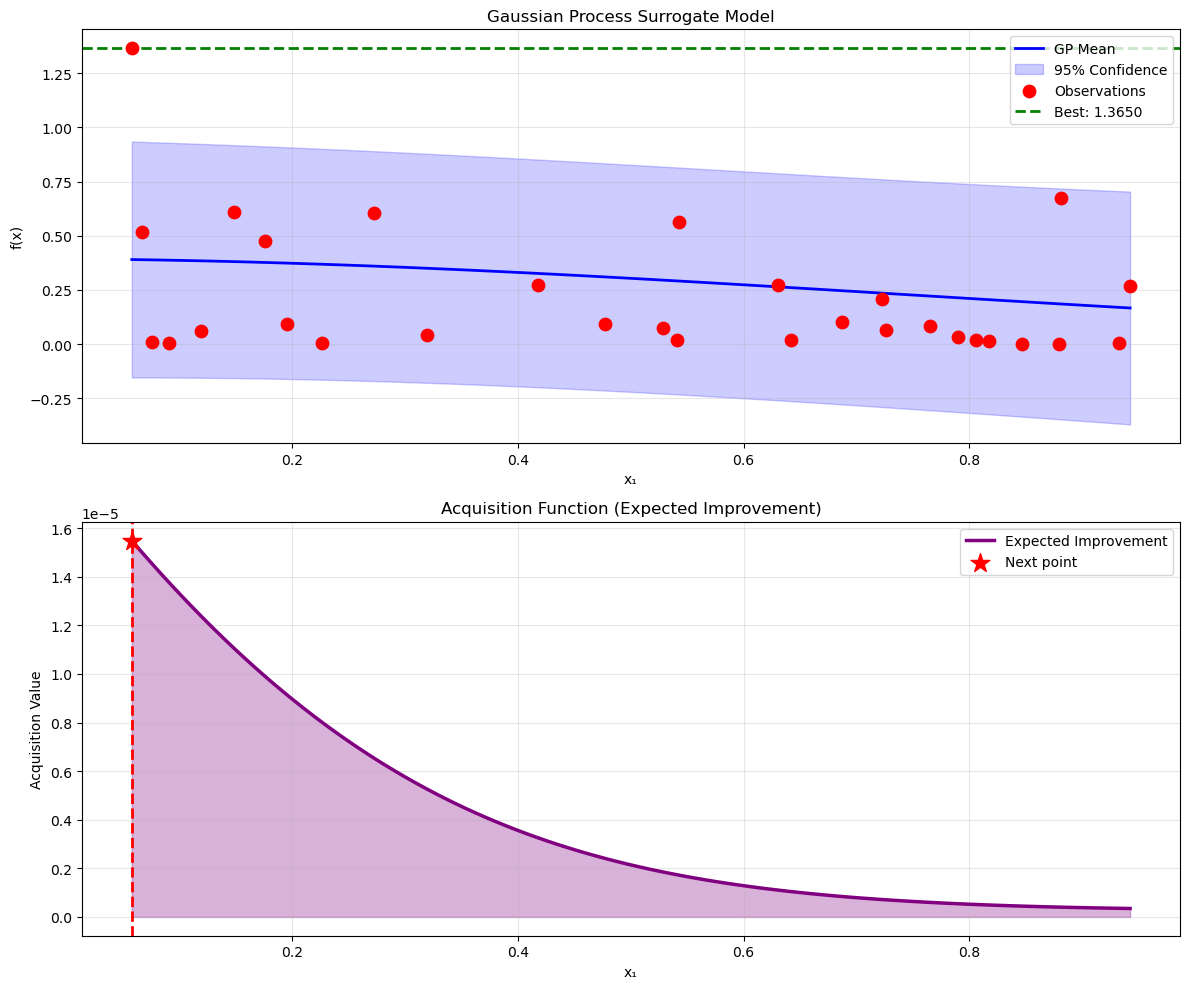

In [152]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10)) 
# Top plot: GP surrogate 
ax1.plot(x_plot[:, 0], mv, 'b-', label='GP Mean', linewidth=2) 
ax1.fill_between(x_plot[:, 0], mv - 1.96*sigma, mv + 1.96*sigma, alpha=0.2, color='blue', label='95% Confidence') 
ax1.scatter(X[:, 0], Y, c='red', s=80, zorder=10, label='Observations') 
ax1.axhline(y=y_best, color='green', linestyle='--', linewidth=2, label=f'Best: {y_best:.4f}') 
ax1.set_xlabel('x₁') 
ax1.set_ylabel('f(x)') 
ax1.set_title('Gaussian Process Surrogate Model') 
ax1.legend() 
ax1.grid(True, alpha=0.3) 
# Bottom plot: Acquisition function (EI)
ax2.plot(x_plot[:, 0], EI, 'purple', linewidth=2.5, label='Expected Improvement') 
ax2.axvline(x=x_next[0], color='red', linestyle='--', linewidth=2) 
ax2.scatter(x_next[0], np.max(EI), c='red', s=200, marker='*', zorder=10, label=f'Next point') 
ax2.fill_between(x_plot[:, 0], 0, EI, alpha=0.3, color='purple') 
ax2.set_xlabel('x₁') 
ax2.set_ylabel('Acquisition Value') 
ax2.set_title('Acquisition Function (Expected Improvement)') 
ax2.legend() 
ax2.grid(True, alpha=0.3) 
plt.tight_layout() 
plt.show()

In [153]:
##Now look for the UCB

In [154]:
# UCB Acquisition Function - Create 6D prediction grid
kappa = 2.0  # Exploration parameter

# Create grid for UCB (X1 varies, others fixed at mean)
n_points = 300
x1_ucb = np.linspace(X[:, 0].min(), X[:, 0].max(), n_points)

x_plot_ucb = np.column_stack([
    x1_ucb,
    np.full(n_points, X[:, 1].mean()),
    np.full(n_points, X[:, 2].mean()),
    np.full(n_points, X[:, 3].mean()),
    np.full(n_points, X[:, 4].mean()),
    np.full(n_points, X[:, 5].mean()),
])

print(f'UCB grid created: {x_plot_ucb.shape}')
print(f'Grid is 6D: X1 varies, others fixed at their means')


UCB grid created: (300, 6)
Grid is 6D: X1 varies, others fixed at their means


In [155]:
##Find Next sampling point

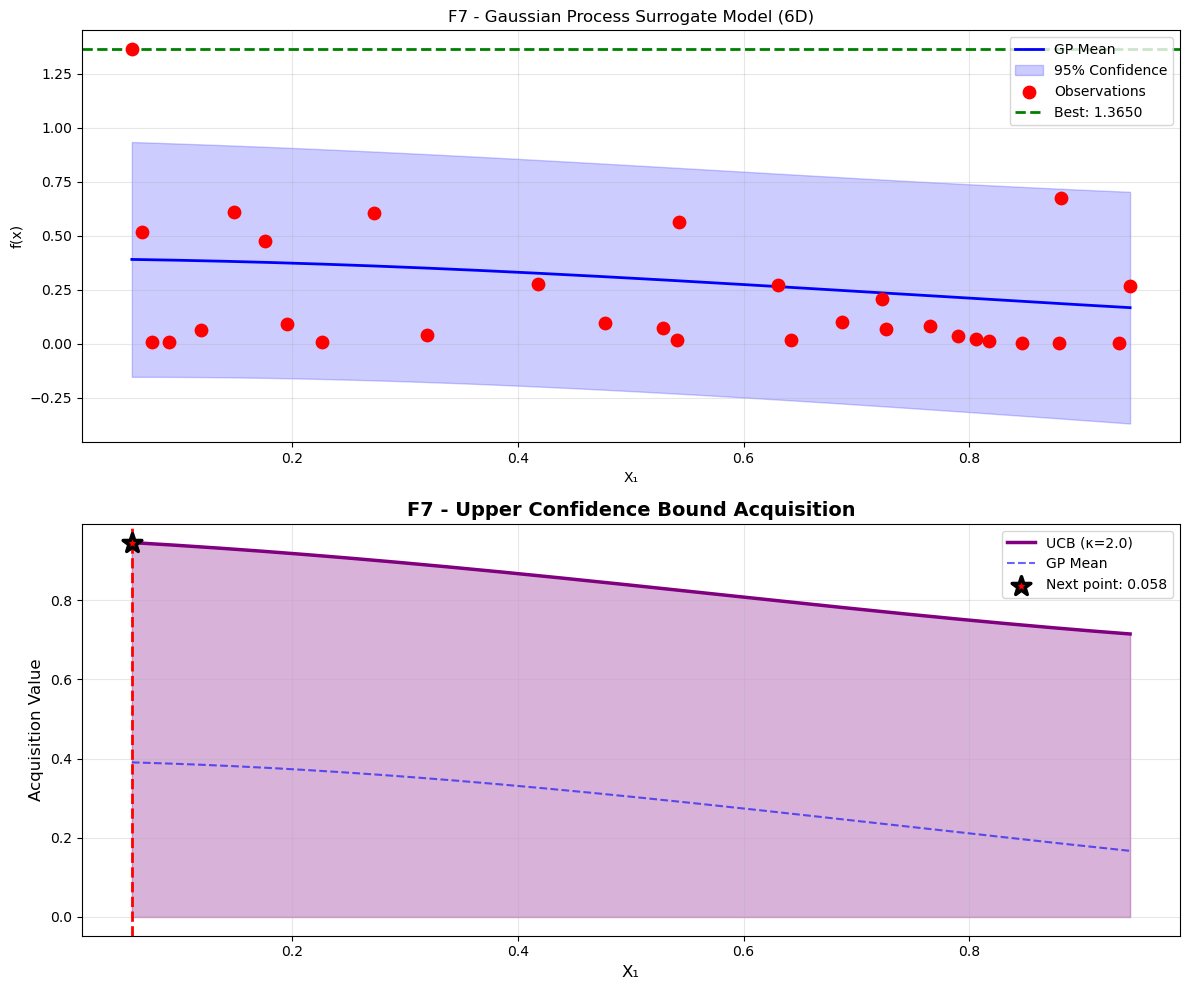


UCB suggests next point for F7: [0.05789554 0.3958027  0.38960883 0.51281929 0.46720062 0.48470376]


In [156]:
# Generate predictions on UCB grid
mv_ucb, sigma_ucb = gp.predict(x_plot_ucb, return_std=True)
UCB = mv_ucb + kappa * sigma_ucb

# Find best UCB point
x_next_idx = np.argmax(UCB)
x_next_ucb = x_plot_ucb[x_next_idx]
y_best_ucb = Y.max()

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top plot: GP surrogate
ax1.plot(x_plot_ucb[:, 0], mv_ucb, 'b-', label='GP Mean', linewidth=2)
ax1.fill_between(x_plot_ucb[:, 0], mv_ucb - 1.96*sigma_ucb, mv_ucb + 1.96*sigma_ucb,
                 alpha=0.2, color='blue', label='95% Confidence')
ax1.scatter(X[:, 0], Y, c='red', s=80, zorder=10, label='Observations')
ax1.axhline(y=y_best_ucb, color='green', linestyle='--', linewidth=2,
            label=f'Best: {y_best_ucb:.4f}')
ax1.set_xlabel('X₁')
ax1.set_ylabel('f(x)')
ax1.set_title('F7 - Gaussian Process Surrogate Model (6D)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom plot: UCB acquisition function
ax2.plot(x_plot_ucb[:, 0], UCB, 'purple', linewidth=2.5,
         label=f'UCB (κ={kappa})')
ax2.plot(x_plot_ucb[:, 0], mv_ucb, 'b--', linewidth=1.5, alpha=0.6,
         label='GP Mean')
ax2.axvline(x=x_next_ucb[0], color='red', linestyle='--', linewidth=2)
ax2.scatter(x_next_ucb[0], np.max(UCB), c='red', s=200, marker='*',
            zorder=10, edgecolors='black', linewidth=2.5,
            label=f'Next point: {x_next_ucb[0]:.3f}')
ax2.fill_between(x_plot_ucb[:, 0], 0, UCB, alpha=0.3, color='purple')
ax2.set_xlabel('X₁', fontsize=12)
ax2.set_ylabel('Acquisition Value', fontsize=12)
ax2.set_title('F7 - Upper Confidence Bound Acquisition', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\nUCB suggests next point for F7: {x_next_ucb}')


In [157]:
# Now print the next best sampling points for UCB and EI

In [158]:
print("\n" + "="*60) 
print("QUERY SUBMISSION") 
print("="*60) 
print(f"UCB data gives next point to sample for Function 7: x_next_ucb = {x_next_ucb[0]:.6f}, {x_next_ucb[1]:.6f},{x_next_ucb[2]:.6f},{x_next_ucb[3]:.6f},{x_next_ucb[4]:.6f},{x_next_ucb[5]:.6f}") 
print(f"EI  data gives next point to sample for Function 7: x_next = {x_next[0]:.6f}, {x_next[1]:.6f},{x_next[2]:.6f},{x_next[3]:.6f},{x_next[4]:.6f},{x_next[5]:.6f}")
print("="*60)


QUERY SUBMISSION
UCB data gives next point to sample for Function 7: x_next_ucb = 0.057896, 0.395803,0.389609,0.512819,0.467201,0.484704
EI  data gives next point to sample for Function 7: x_next = 0.057896, 0.395803,0.389609,0.512819,0.467201,0.484704


In [159]:
 # generate random data points
from scipy.stats import norm

def expected_improvement(X_new,gp,y_best,xi=0.01):
     mv,sigma= gp.predict(X_new,return_std=True)
     sigma = np.maximum(sigma,1e-10)
     imp = mv-y_best -xi
     Z = imp/sigma
     ei = imp*norm.cdf(Z)+sigma * norm.pdf(Z)
     ei[sigma < 1e-10] =0.0
     return ei

kernel  = ConstantKernel(1.0,constant_value_bounds=(1e-10,1e10)) * RBF(length_scale=0.3,  length_scale_bounds=(0.01,10.0)) \
+ WhiteKernel(noise_level=1e-10, noise_level_bounds=(1e-12,1e-2))
gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 30, normalize_y=False, random_state=42)
gp.fit(X,Y)
n_candidates = 5000
candidates = np.random.uniform(0,1,size=(n_candidates,6))

#compute acquision curve on candidates

acquisition_type = "UCB"
#acquisition_type = "EI"

best_idx= None

if acquisition_type == "EI":
    y_best = Y.max()
    ei_values = expected_improvement(candidates,gp,y_best=y_best,xi=0.01)
    best_idx=np.argmax(ei_values)
    print("Using Expected Improvement (EI)")
elif  acquisition_type == "UCB":
      mv,sigma=gp.predict(candidates,return_std=True)
      ucb_values = mv+2.0*sigma
      best_idx = np.argmax(ucb_values)
      print("Using Upper Confidence Bounds (UCB)")
else:
    raise ValueError("Invalid acquision type")
if acquisition_type == "UCB":
    x_next = candidates[best_idx]
    x_next = np.clip(x_next,0.0,1.0)
    
print("Random data: Next point from random candidates:",x_next)
print("Random Data: GP fitted. Learned kernal :",gp.kernel_)

Using Upper Confidence Bounds (UCB)
Random data: Next point from random candidates: [0.0976462  0.22418861 0.31226974 0.1300089  0.27712346 0.69710733]
Random Data: GP fitted. Learned kernal : 0.36**2 * RBF(length_scale=0.388) + WhiteKernel(noise_level=2.91e-12)
